In [1]:
#Description: This program shows you how to create a artificial recurrent neural network called Long Short Term Memory(LSTM).
# How to predict the closing stock price of a corporation (Apple Inc.).

In [2]:
!pip show pandas_datareader


Name: pandas-datareader
Version: 0.10.0
Summary: Data readers extracted from the pandas codebase,should be compatible with recent pandas versions
Home-page: https://github.com/pydata/pandas-datareader
Author: The PyData Development Team
Author-email: pydata@googlegroups.com
License: BSD License
Location: /usr/local/lib/python3.7/dist-packages
Requires: lxml, requests, pandas
Required-by: 


In [3]:
#Importing the required libraries
import math
import pandas_datareader as web
import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') #just the matplotlib style named as fivethirtyeight

In [5]:
#Getting the stock quote 
start_date = datetime.datetime(2015, 1, 1)
end_date = datetime.datetime(2021, 9, 29)
#df = web.DataReader("PG", "yahoo",start_date, end_date)
#df = web.get_data_yahoo("AAPL", start_date, end_date)
df = web.DataReader('AAPL', data_source='yahoo', start="2012-01-01", end="2021-01-01") #dataframe captured using yahoo finances api

df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.591939
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.659608
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.800157
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.933965
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.913450
...,...,...,...,...,...,...
2020-12-24,133.460007,131.100006,131.320007,131.970001,54930100.0,131.161407
2020-12-28,137.339996,133.509995,133.990005,136.690002,124486200.0,135.852509
2020-12-29,138.789993,134.339996,138.050003,134.869995,121047300.0,134.043640


In [6]:
df.shape #Showing number of rows and cols

(2265, 6)

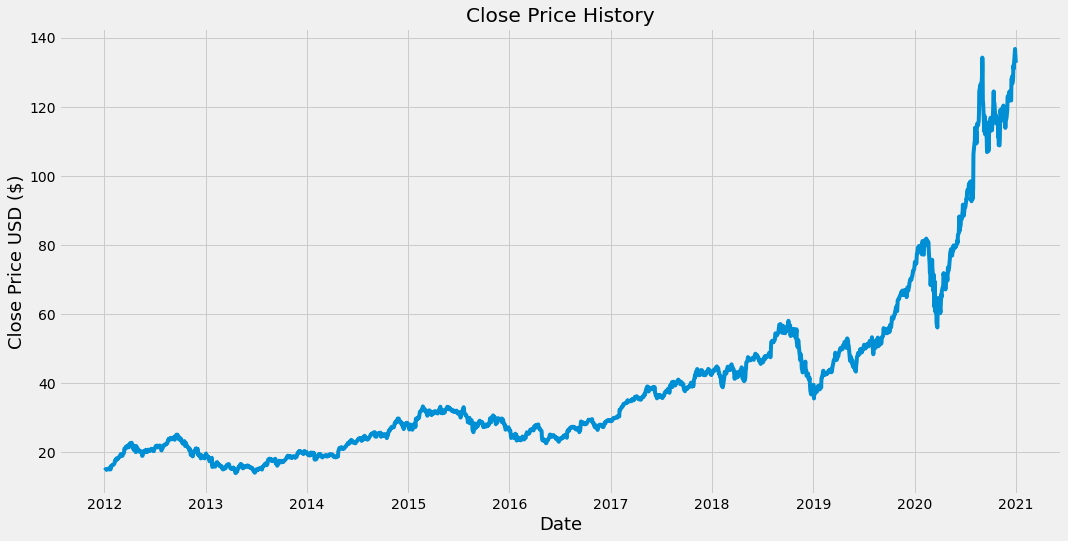

In [7]:
#Plotting the closing price history graph using matplotlib library
plt.figure(figsize=(16,8),edgecolor='Black')  #Graph with 16 inch width and 8 inch height and border color black
plt.title('Close Price History')  #Title of the graph
plt.plot(df['Close']) #Plotting using dataframe df with only colomn name close
plt.xlabel('Date',fontsize=18)  #label of graph on x-axis
plt.ylabel('Close Price USD ($)',fontsize=18) #label of graph on y-axis
plt.show()

In [8]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) #Considering the 80% of data in training data

In [9]:
#Scale all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) #Using MinMaxScaler function for scaling the data as it is good if we use preprocessed data
scaled_data = scaler.fit_transform(dataset) #Transforming the dataset into scaled data in range of 0 and 1 inclusive.

In [10]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ] #Taking rows from 0 to 80% of whole data and all columns
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []

for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])  #x train contains 1st 59 data set
    y_train.append(train_data[i,0]) #y train contains remaining data sets

In [11]:
#Convert x_train and y_train to numpy arrays, so we can use them for training
x_train, y_train = np.array(x_train), np.array(y_train)

In [12]:
#Reshape the data into the shape accepted by the LSTM that is 3 dimensional
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [13]:
#Build the LSTM network model
model = Sequential()  #Building model using keras library
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1))) #1st LSTM layer with 50 neurons and kepping return sequences to true
model.add(LSTM(units=50, return_sequences=False)) #2nd LSTM layer with 50 neurons and kepping return sequences to false
model.add(Dense(units=25))  #3rd Dense layer of 25 neurons
model.add(Dense(units=1)) #4th Dense layer of 25 neurons

In [14]:
#Compile the model
#Adam optimizer is used because it is straight forward to use and it can be used instead of Stochastic optimization
#mean_squared_parameter Computes the mean of squares of errors between labels and predictions
model.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1) 
#fit is another name for train
#batch size is total number of training example present 
#epochs is number of iterations when entire data set is passed forward or backward through neural network

1752/1752 [==============================] - 52s 28ms/step - loss: 2.6711e-04


In [16]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] 
#Get all of the rows from index 1762 to the rest and all of the columns (in this case it's only column 'Close'), so 2202 - 1762 = 440 rows of data

for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [17]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

In [18]:
#Similarly, reshape the data into the shape accepted by the LSTM that is 3 dimensional
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [19]:
#Getting the models predicted price values by test data
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#When the binary labels are fractional, inverse_transform chooses the class with the greatest value

In [20]:
#Calculating the value of RootMeanSquaredError(RMSE)
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse
#It is a great way to find how accurate the model is
#The lower the value, the better is the model performing

7.953206463147004

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


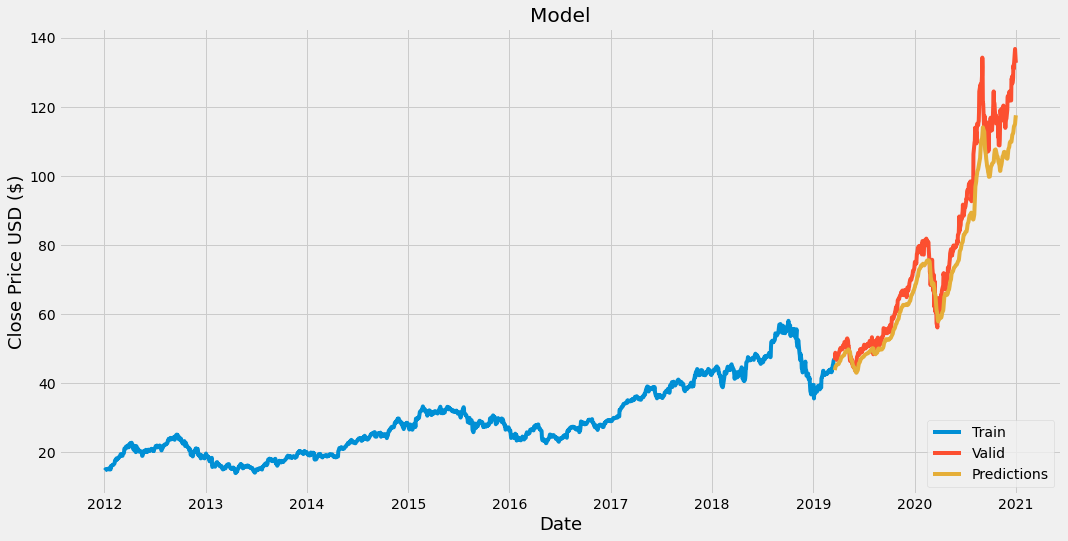

In [21]:
#Plot the data for the graph
train = data[:training_data_len]  #This is the range on what the model is trained on
valid = data[training_data_len:]  #This is the predicted data 
valid['Predictions'] = predictions

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.show()

In [22]:
#Showing the valid and predicted prices
valid

,Close,Predictions
Date,,
2019-03-19,46.632500,43.751671
2019-03-20,47.040001,44.086636
2019-03-21,48.772499,44.390392
2019-03-22,47.762501,44.829693
2019-03-25,47.185001,45.172554
...,...,...
2020-12-24,131.970001,114.250397
2020-12-28,136.690002,114.932457
2020-12-29,134.869995,116.036354


In [23]:
#So, this is the whole project and the accuracy is very good and the predicted values are very close.

In [24]:
#Get the quote
apple_quote = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2020-10-5')
#Create a new dataframe
new_df = apple_quote.filter(['Close'])
#Get teh last 60 day closing price 
last_60_days = new_df[-60:].values
#Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = []
#Append teh past 60 days
X_test.append(last_60_days_scaled)
#Convert the X_test data set to a numpy array
X_test = np.array(X_test)
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#Get the predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling 
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[103.47086]]


In [25]:
#Get the quote
apple_quote2 = web.DataReader('AAPL', data_source='yahoo', start='2020-9-11', end='2020-9-11')
print(apple_quote2['Close'])

Date
2020-09-11    112
Name: Close, dtype: int64
